**ThreadShift**

Segmentation, Image Editing and Generation with the aid of Stable Diffusion

Course Project (TYITA B1 G2)


Using GPT to generate visualization function (optional, requires OpenAI API)

# **Libraries used for optimisation**

**ftfy**: Fixes broken Unicode text

**regex**: Advanced regular expressions library for searching and manipulating text.

**tqdm**: Fast, extensible progress bar for loops and iterable objects.

**diffusers by Hugging Face:**: Diffusers provides pretrained vision and audio diffusion models, and serves as a modular toolbox for inference and training

**transformers by Hugging Face:**:  Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.

**scipy**: Scientific computing library for optimization, integration, and other mathematical operations.

**accelerate by Hugging Face**: In short, training and inference at scale made simple, efficient and adaptable

**Xformers**: Optimizes transformers architecture. Toolbox to Accelerate Research on Transformers

**opencv**: OpenCV is a library of programming functions mainly for real-time computer vision


In [9]:
### Install Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python


In [10]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray


In [11]:
### Import Clip and ClipSeg repositories

# Install Clip from OpenAI ## MIT Licence
!pip install -q git+https://github.com/openai/CLIP.git

# Install ClipSeg Repo ## MIT Licence
!git clone https://github.com/timojl/clipseg

  Preparing metadata (setup.py) ... done
Cloning into 'clipseg'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 229 (delta 72), reused 58 (delta 58), pack-reused 140
Receiving objects: 100% (229/229), 1.40 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [12]:
# Important: Move into the ClipSeg folder
%cd clipseg

/content/clipseg/clipseg


In [13]:
### Get the weights for the ClipSeg model
### These weights don't have MIT licence, they can only be used for research, not for commercial purposes
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip


--2023-10-04 07:01:04--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [    <=>             ]   9.68M  11.6MB/s    in 0.8s    

2023-10-04 07:01:05 (11.6 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [14]:
# Import Clip and ClipSeg model
import clip
from models.clipseg import CLIPDensePredT

# load clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

# non-strict mode: decoder weights only (no CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);

In [15]:
### Import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Source image size: (3923, 5811)
Target image size: (512, 512)


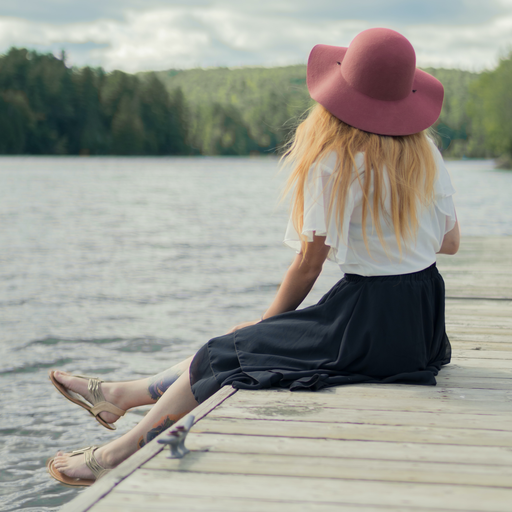

In [16]:
### Link: https://unsplash.com/photos/AsJirOOLN_s

### IMPORTANT: Upload the unsplash image inside the clipseg folder

target_width, target_height = 512,512
source_image = Image.open('/content/mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

### Setup transformations to be applied to the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_image = transform(source_image).unsqueeze(0)

display(source_image)

In [17]:
#### Create masks for the parts of the clothes to be identified

prompts = ['a hat', 'a dark skirt', 'shoes', 'a white shirt']

# Use ClipSeg to identify elements in picture
with torch.no_grad():
    preds = model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]



Overall, the function create_image_grid is designed to visualize a grid of images, including an original image and additional images with corresponding titles, making use of Matplotlib for display.

In [18]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


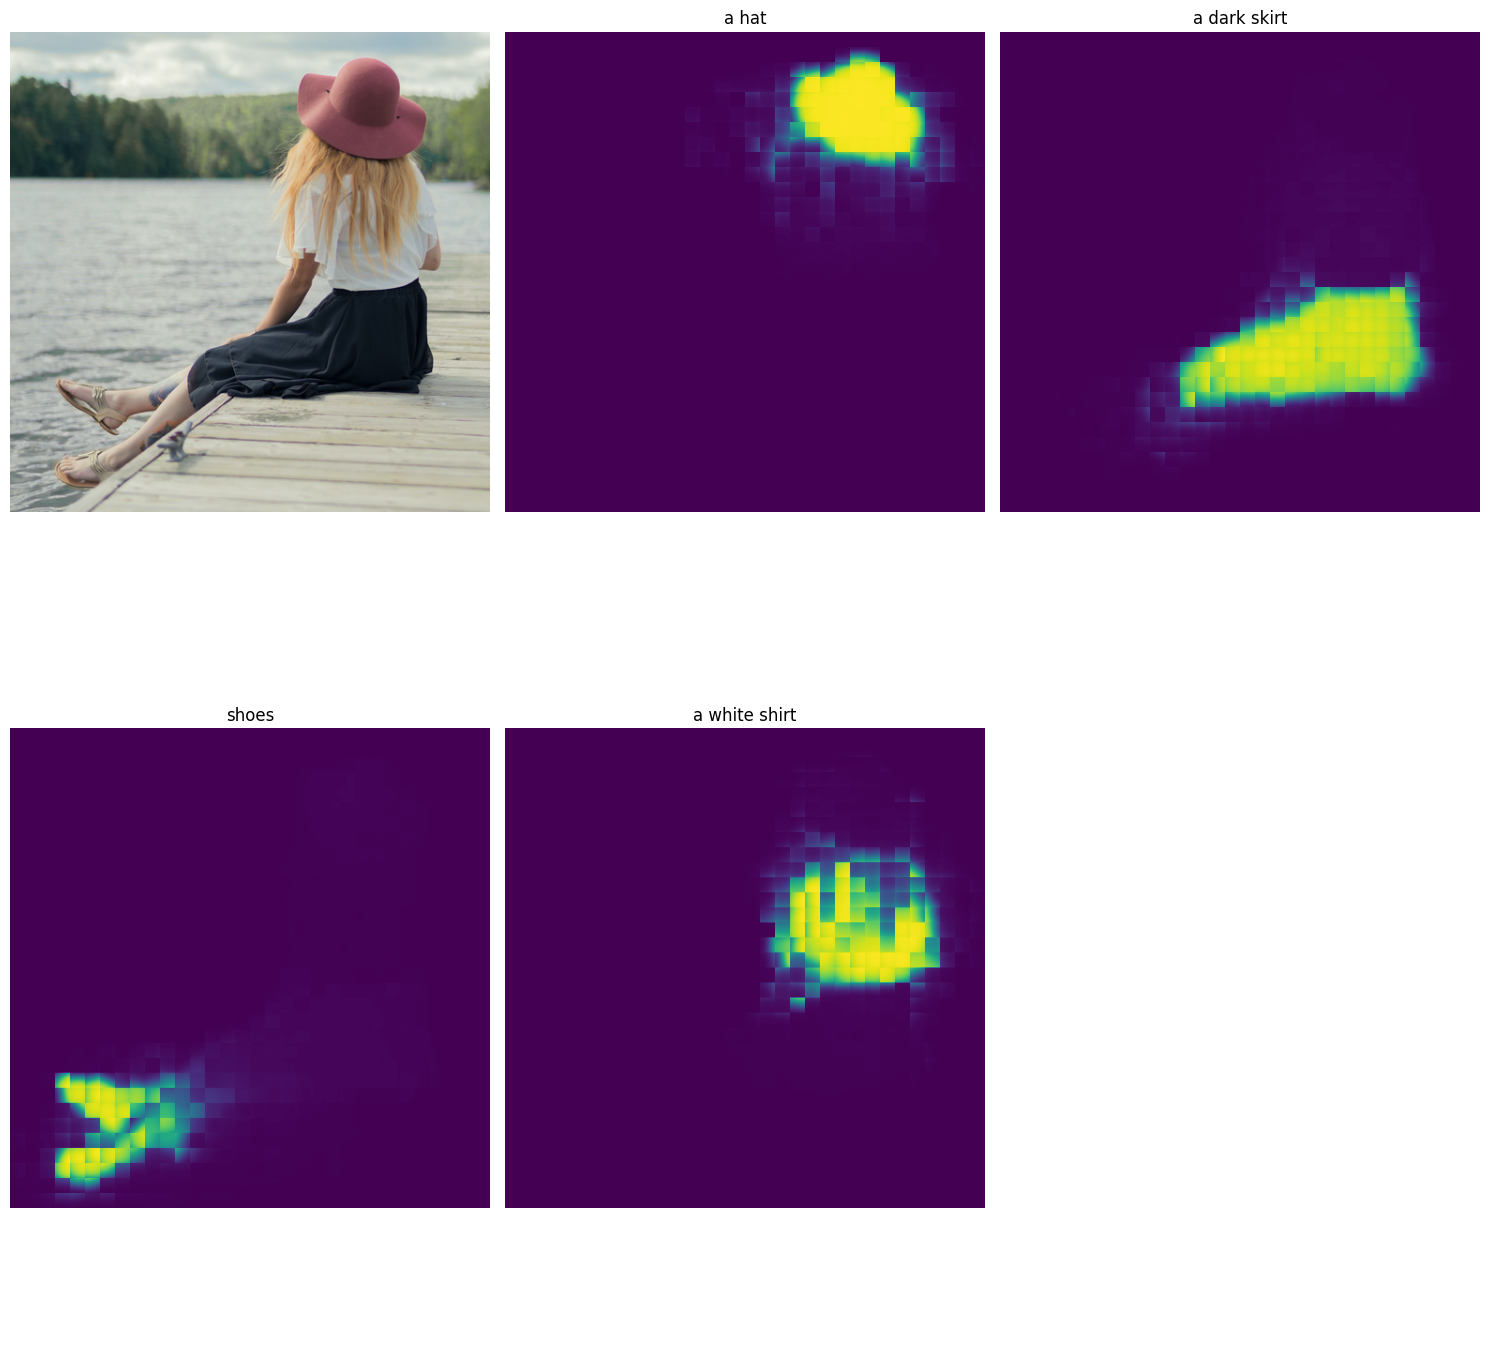

In [19]:
create_image_grid(source_image, preds, prompts, 2, 3)

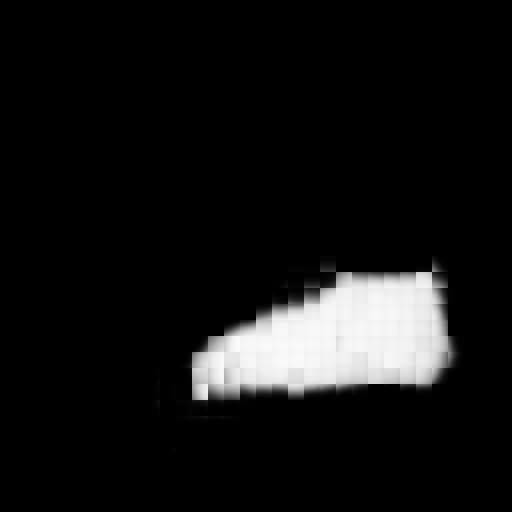

In [20]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 1
mask_number = 1

# Normalize mask values by computing the area under Gaussan probability density function, calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_number][0])

stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)

We set up prompts for inpainting, initialize a generator, and runs the Stable Diffusion pipeline to inpaint images based on the specified prompts and parameters. The resulting inpainted images are collected in the encoded_images list.

Masks are used to modulate the contribution of the original image to the final blended result, enhancing the visual appeal of the inpainting process. They allow for a controlled and smooth transition between the inpainted regions and the original image.

In [21]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Normalize tensor images, convert them to 3-channel format, and blend them with the original image
        images = [
            cv2.add(
                original_image_np,
                cv2.applyColorMap((torch.sigmoid(img).squeeze(0).numpy() * 255).astype(np.uint8), cv2.COLORMAP_HOT)[:,:,[2,1,0]] * (torch.sigmoid(img).squeeze(0).numpy() > 0.5).astype(np.uint8)[:, :, np.newaxis]
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


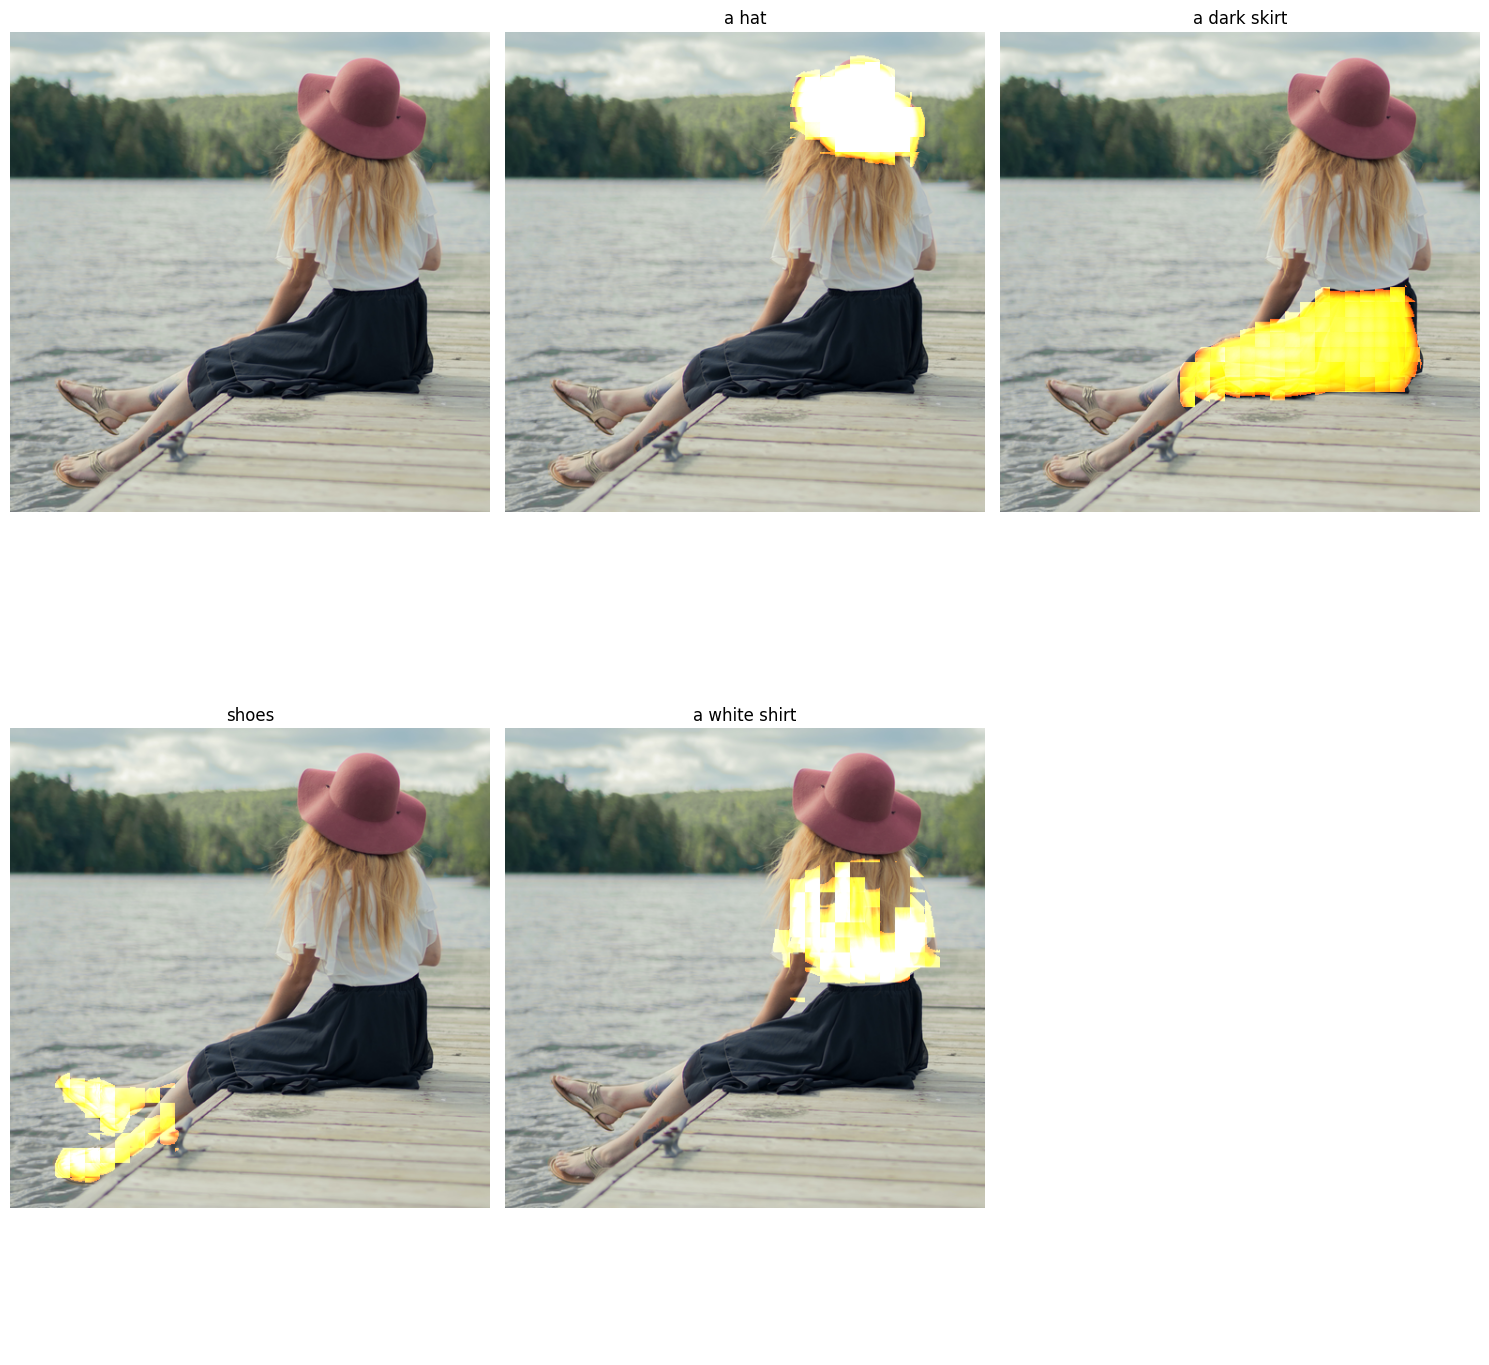

In [22]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

 The modified code achieves the same goal of creating a grid of images with masks and names, but with a slightly different approach to blending images using NumPy functions (np.where) compared to the previous version that used OpenCV functions (cv2.add).

In [23]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Normalize tensor images, convert them to 3-channel format, and blend them with the original image
        images = [
            np.where(
                (torch.sigmoid(img).squeeze(0).numpy() > 0.5)[:, :, np.newaxis],
                cv2.applyColorMap((torch.sigmoid(img).squeeze(0).numpy() * 255).astype(np.uint8), cv2.COLORMAP_HOT)[:,:,[2,1,0]],
                original_image_np
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


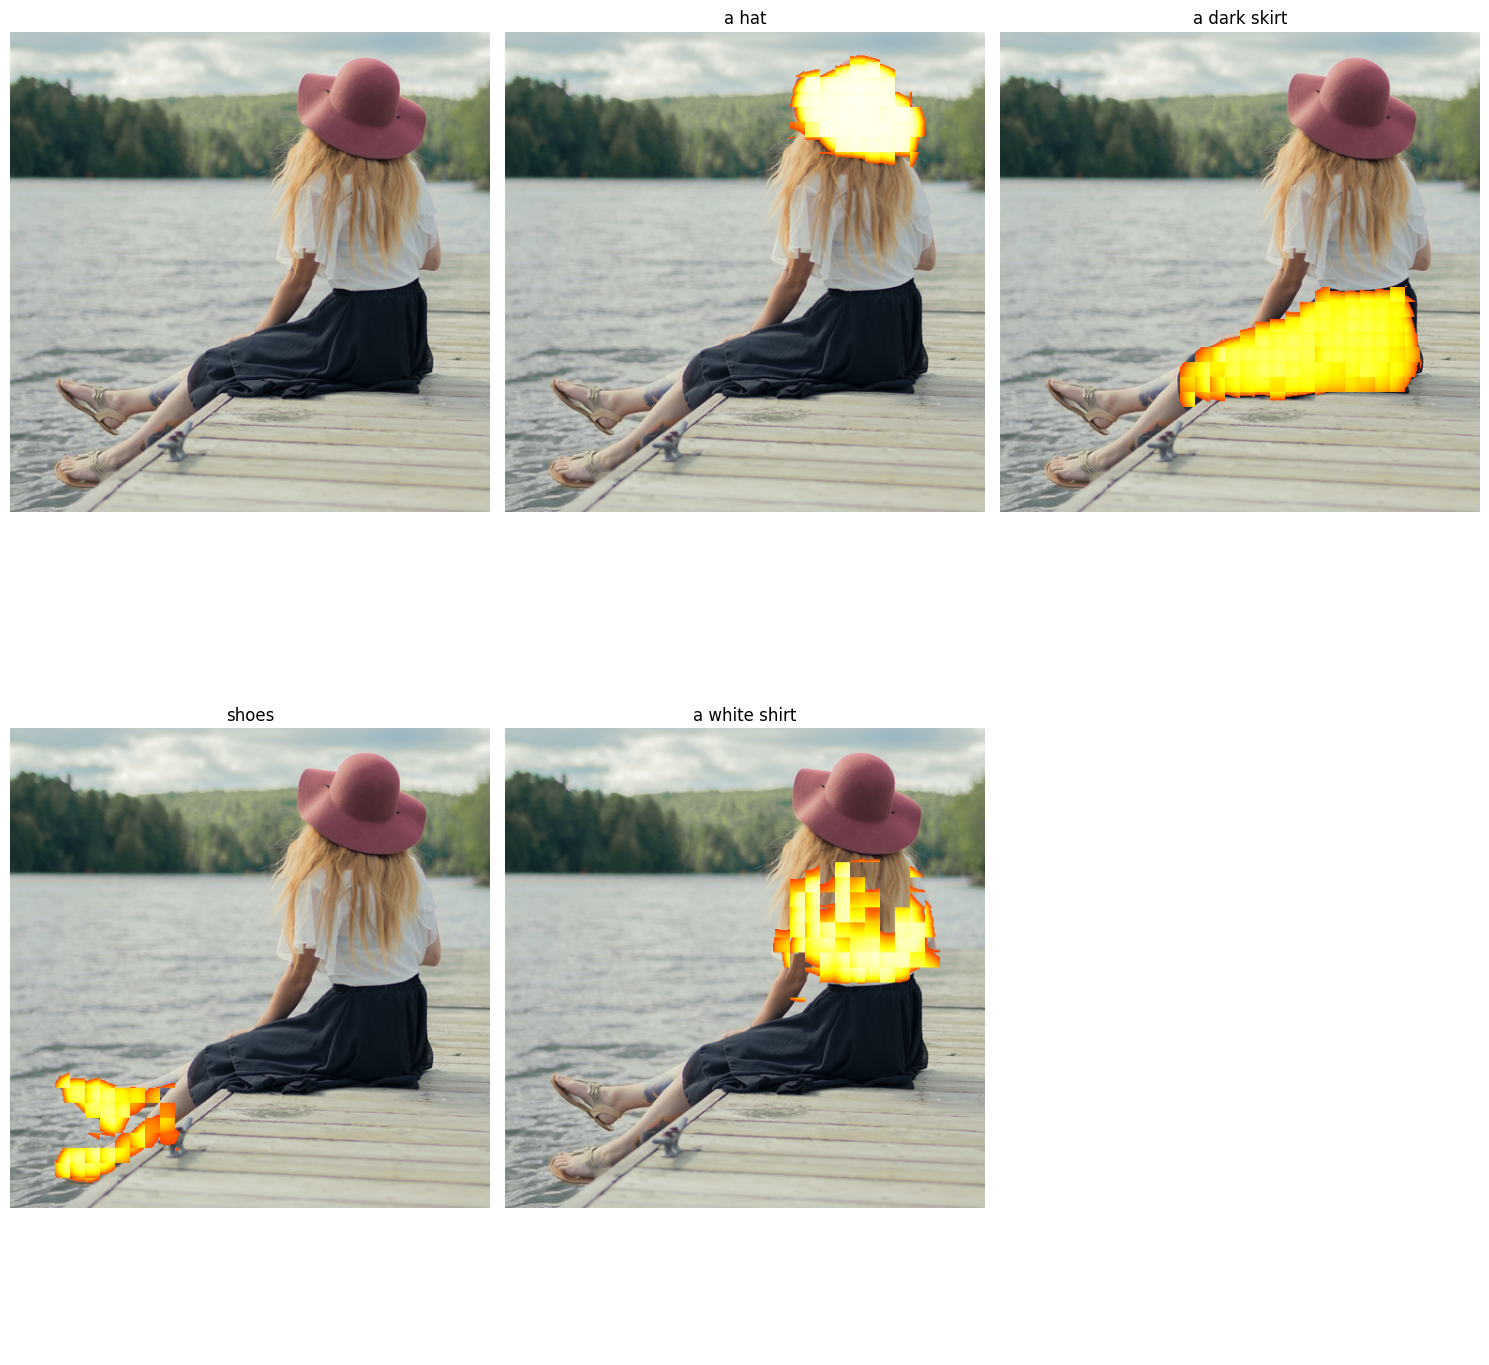

In [24]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

A yellow color mask is created with the same size as the original image. This is different from the previous versions where blending was done with a colormap or directly with the original image based on a binary mask.

In [25]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Create a solid yellow color mask with the same size as the original image
        yellow_mask = np.zeros_like(original_image_np)
        yellow_mask[..., 0] = 255  # Red channel
        yellow_mask[..., 1] = 255  # Green channel

        # Normalize tensor images, create a binary mask, and blend them with the original image
        images = [
            np.where(
                (torch.sigmoid(img).squeeze(0).numpy() > 0.5)[:, :, np.newaxis],
                yellow_mask,
                original_image_np
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


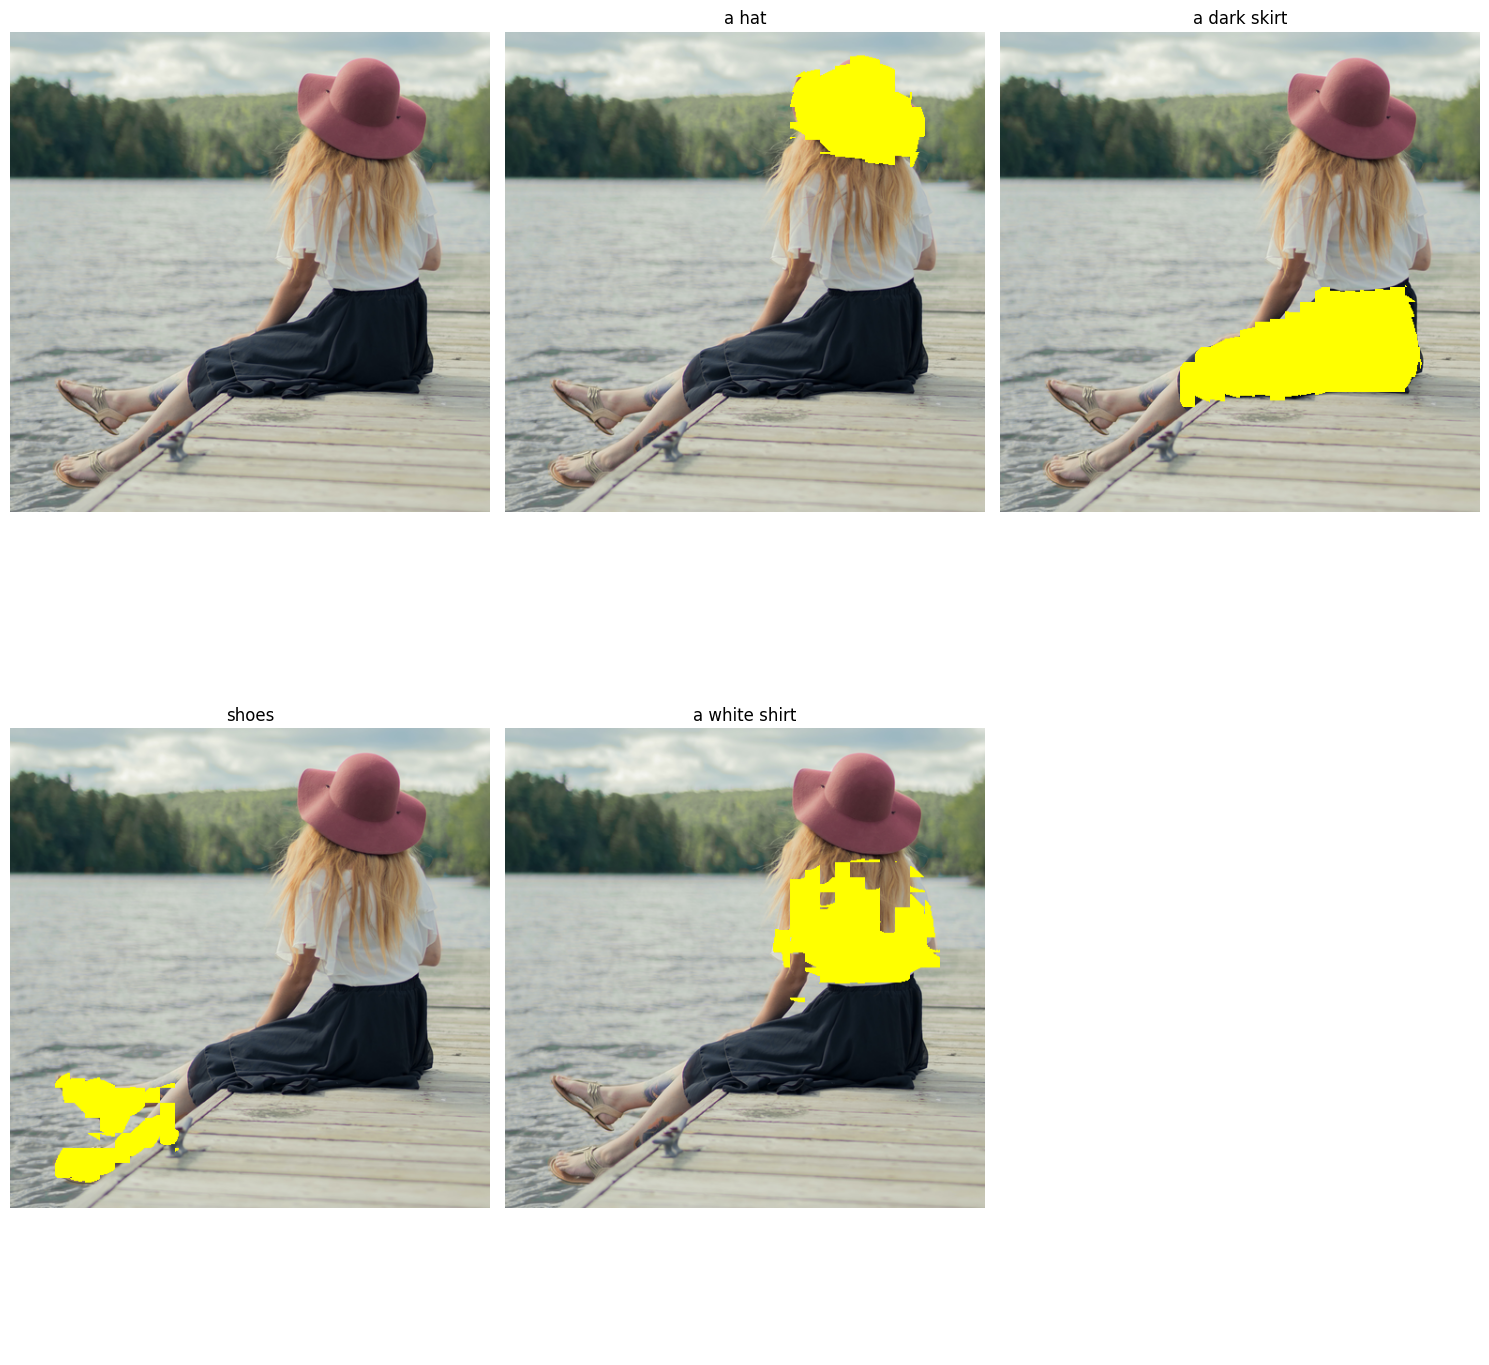

In [26]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

In [27]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["blue jeans",  "blue flowers", "white flowers", "a zebra skirt"]

generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

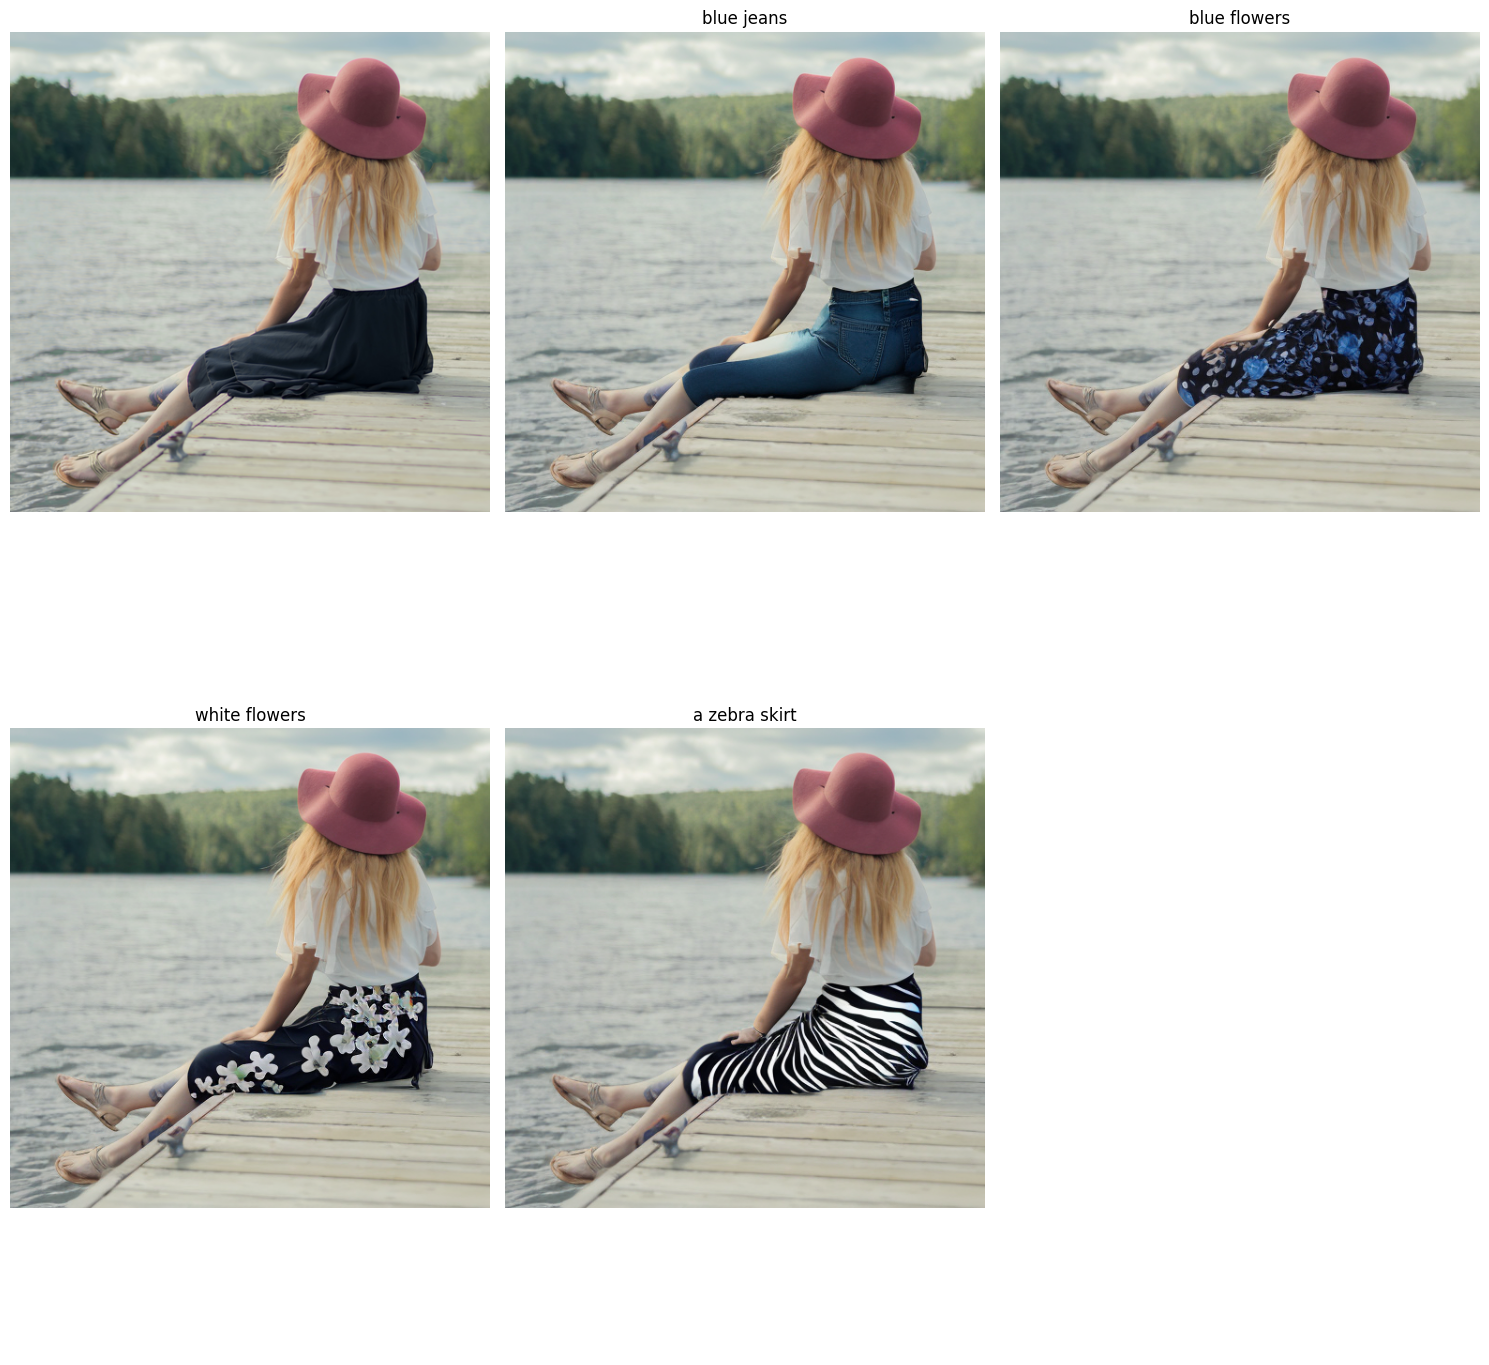

In [28]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)